In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


one year ago before last date of dataset: 2016-08-23


<Figure size 1000x500 with 0 Axes>

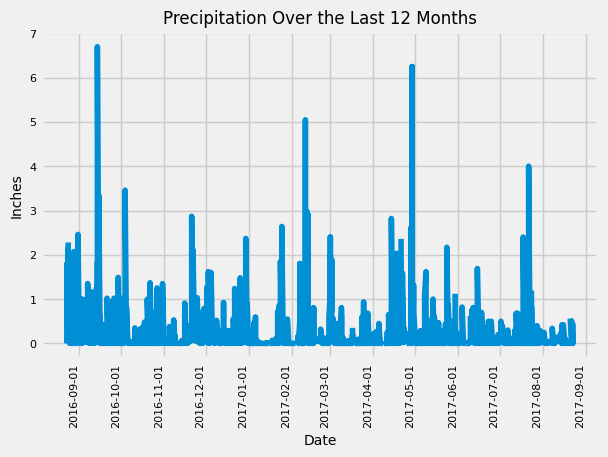

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"one year ago before last date of dataset: {year_ago}")

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precip_df = pd.DataFrame(precip_data, columns=["date", "precipitation"])
#reassuring that data will be saved in date format
precip_df["date"] = pd.to_datetime(precip_df["date"])
precip_df.set_index("date", inplace=True)

# Sort the dataframe by date
plt.figure(figsize=(10, 5))
precip_df.plot(rot=90, legend=None)

# Use Pandas Plotting with Matplotlib to plot the data, checking fonts sizes
plt.title("Precipitation Over the Last 12 Months", fontsize=12) 
plt.xlabel("Date", fontsize=10) 
plt.ylabel("Inches", fontsize=10)


# Adjusting date formatting
import matplotlib.dates as mdates
ax = plt.gca()  
# Show dates every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Smaller x-axis ticks for nicer outlook
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).distinct().scalar()
print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in stations:
    print(f"Station: {station}, Observations: {count}")

Most Active Stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations[0][0]
print(f"Most Active Station: {most_active_station}")

# Query to get min, max, and avg temperature for the most active station
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temp_stats[0]

print(f"Temperature statistics for station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Most Active Station: USC00519281
Temperature statistics for station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


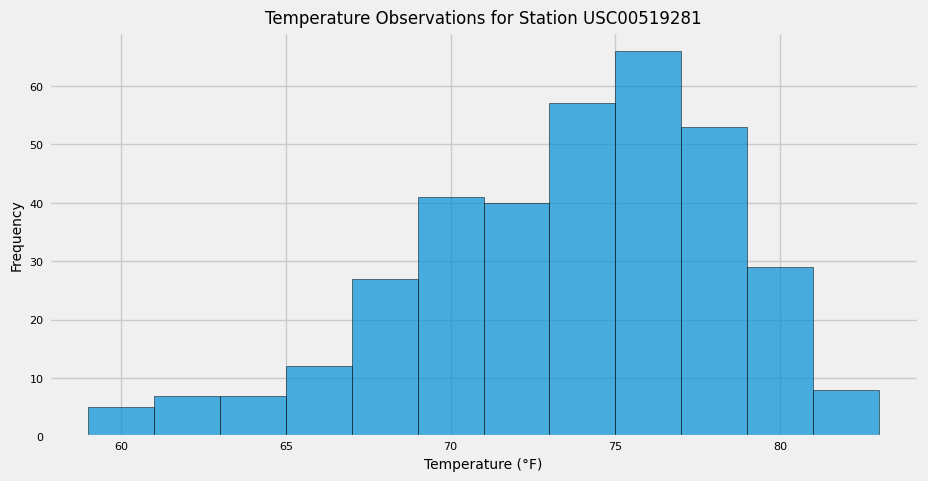

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results 
# as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= year_ago).all()

#creating DF we shall use for our plot
temp_df = pd.DataFrame(temp_data, columns=["temperature"])

plt.figure(figsize=(10, 5))
plt.hist(temp_df["temperature"], bins=12, edgecolor="black", alpha=0.7)

# outlook touch ups
plt.title(f"Temperature Observations for Station {most_active_station}", fontsize=12)
plt.xlabel("Temperature (°F)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.show()

# Close Session

In [16]:
# Close Session
session.close()